In [91]:
import pickle
import os
import shutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred, label_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label='ped', average='binary')
    recall = recall_score(y_true, y_pred, pos_label='ped', average='binary')
    f1 = f1_score(y_true, y_pred, pos_label='ped', average='binary')
    print(f"\nMetrics for {label_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return accuracy, precision, recall, f1

# path = '/Users/tomercohen/Downloads/crop2vec_chatgpt/Manual_Tagged_crops_multi_context/results_withmaybe_all.pkl'
path = '/Users/tomercohen/Downloads/crop2vec_chatgpt/Manual_Tagged_crops_multi_context/results_withmaybe_shortPrompt_all.pkl'
maybe_images_dir = os.path.join(os.path.dirname(path), "maybe_images")

# Create directory for 'maybe' images if it doesn't exist
if not os.path.exists(maybe_images_dir):
    os.makedirs(maybe_images_dir)

with open(path, 'rb') as f:
    results = pickle.load(f)

# Filter and copy 'maybe' results
maybe_results = []
for i, res in enumerate(results):
    if res['confidence'] < 80 or 'maybe' in res['gpt_pred']:
        maybe_results.append(i)
        # Copy image to 'maybe_images' directory if 'image_path' is available in results
        shutil.copy(res['image_path'], maybe_images_dir)

N = len(results)
results = [res for i, res in enumerate(results) if i not in maybe_results]
print(f"Filtered out {len(maybe_results)}/{N} ({len(maybe_results)/N:.2%}) results with low confidence or 'maybe' in GPT-4 prediction")

# Collect labels and predictions for comparison
manual_gts = [result['manual_gt'] for result in results]
gpt_preds = [result['gpt_pred'] for result in results]

# Calculate metrics for GPT-4 Prediction vs. Manual GT
_ = calculate_metrics(manual_gts, gpt_preds, "GPT-4 Prediction")


Filtered out 30/259 (11.58%) results with low confidence or 'maybe' in GPT-4 prediction

Metrics for GPT-4 Prediction:
Accuracy: 0.8908
Precision: 0.9182
Recall: 0.8632
F1 Score: 0.8899


## Automatic thresohld finding

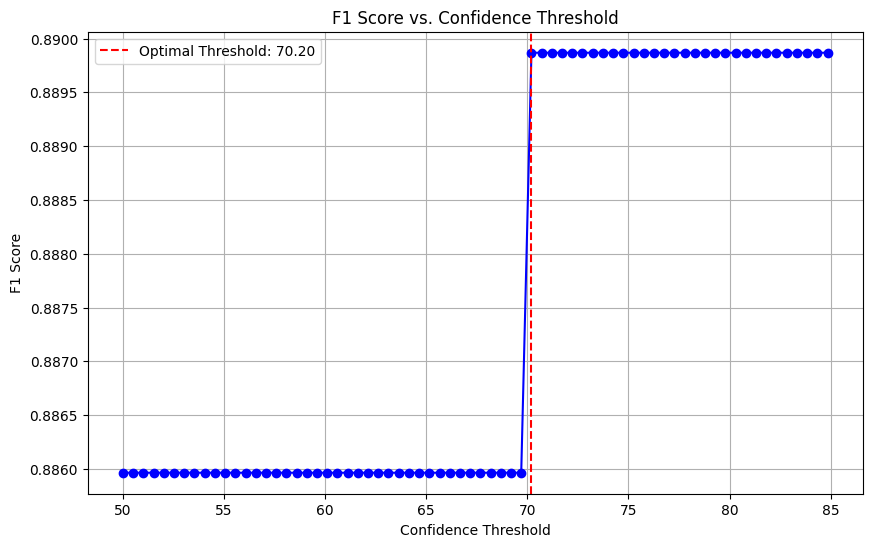


Best Threshold: 70.20
Best F1 Score: 0.8899
Accuracy: 0.8908
Precision: 0.9182
Recall: 0.8632
Percentage of Samples Filtered Out: 11.58%


In [87]:
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(y_true, y_pred, label_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label='ped', average='binary')
    recall = recall_score(y_true, y_pred, pos_label='ped', average='binary')
    f1 = f1_score(y_true, y_pred, pos_label='ped', average='binary')
    return accuracy, precision, recall, f1

# Path to the results file
# path = '/Users/tomercohen/Downloads/crop2vec_chatgpt/Manual_Tagged_crops_multi_context/results_withmaybe_all.pkl'
path = '/Users/tomercohen/Downloads/crop2vec_chatgpt/Manual_Tagged_crops_multi_context/results_withmaybe_shortPrompt_all.pkl'

with open(path, 'rb') as f:
    results = pickle.load(f)

# Define the range of thresholds to evaluate
thresholds = np.linspace(50, 100, 100)  # Adjust the range and step size if needed
f1_scores = []
best_f1 = 0
best_threshold = 0
best_metrics = ()
best_filtered_percentage = 0

# Total number of results
total_results = len(results)

# Iterate over thresholds
for threshold in thresholds:
    filtered_results = [result for result in results if result['confidence'] >= threshold and 'maybe' not in result['gpt_pred']]
    if len(filtered_results) < 0.85 * len(results):  # Ensure not more than 10% of predictions are filtered out
        break

    filtered_gts = [result['manual_gt'] for result in filtered_results]
    filtered_preds = [result['gpt_pred'] for result in filtered_results]
    
    metrics = calculate_metrics(filtered_gts, filtered_preds, f"Threshold {threshold:.2f}")
    f1 = metrics[3]
    f1_scores.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_metrics = metrics
        best_filtered_percentage = 100 * (1 - len(filtered_results) / total_results)

# Plot F1 scores against thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds[:len(f1_scores)], f1_scores, marker='o', linestyle='-', color='b')
plt.title('F1 Score vs. Confidence Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('F1 Score')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {best_threshold:.2f}')
plt.legend()
plt.grid(True)
plt.show()

# Print the best threshold and its corresponding metrics
print(f"\nBest Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Accuracy: {best_metrics[0]:.4f}")
print(f"Precision: {best_metrics[1]:.4f}")
print(f"Recall: {best_metrics[2]:.4f}")
print(f"Percentage of Samples Filtered Out: {best_filtered_percentage:.2f}%")


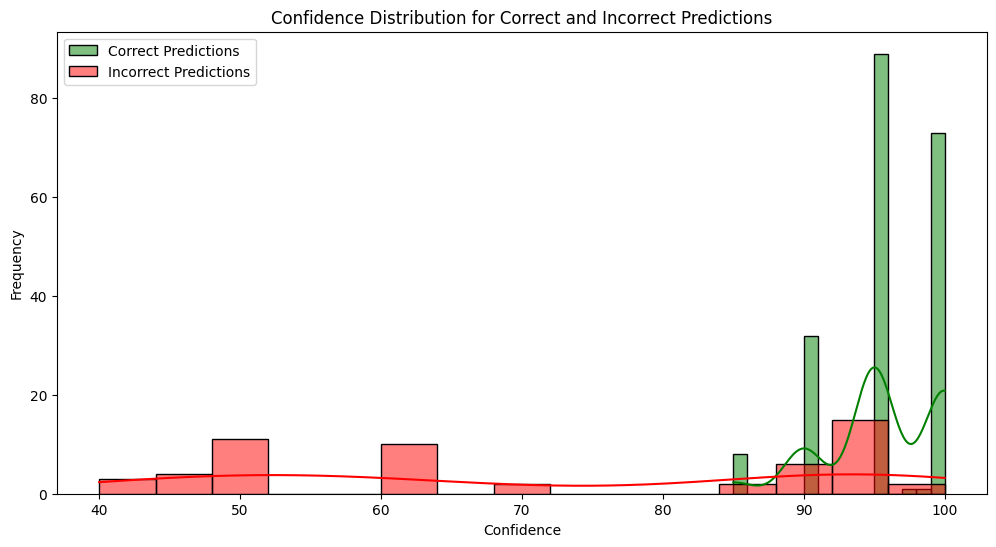

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# path = '/Users/tomercohen/Downloads/crop2vec_chatgpt/Manual_Tagged_crops_multi_context/results_withmaybe_all.pkl'
path = '/Users/tomercohen/Downloads/crop2vec_chatgpt/Manual_Tagged_crops_multi_context/results_withmaybe_shortPrompt_all.pkl'

with open(path, 'rb') as f:
    results = pickle.load(f)


# Assume 'results' is already defined
# Convert to DataFrame
df = pd.DataFrame(results)

# Create a 'correct' column as a Boolean
df['correct'] = (df['gpt_pred'] == df['manual_gt'])

# Convert 'correct' column to string to match palette keys
df['correct'] = df['correct'].astype(str)

# Separate the correct and incorrect predictions
correct_confidence = df[df['correct'] == 'True']['confidence']
incorrect_confidence = df[df['correct'] == 'False']['confidence']

# Plot the histogram
plt.figure(figsize=(12, 6))
sns.histplot(correct_confidence, color='green', label='Correct Predictions', kde=True, bins=15)
sns.histplot(incorrect_confidence, color='red', label='Incorrect Predictions', kde=True, bins=15)
plt.title('Confidence Distribution for Correct and Incorrect Predictions')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.legend()
plt.show()